## Libraries

In [217]:
import numpy as np
import pandas as pd
import re
import time
import json
import pickle
from PersianStemmer import PersianStemmer
from parsivar import FindStems
from hazm import *
import json
from collections import defaultdict
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix, f1_score

## Constants

In [44]:
column_names = ['id','url','text','post_title','header','site_direction','???invisible',
                '???some_tokens','all_nan', 'dominant_category', 'dominant_category_prob',
               'category_probabilities', 'time1', 'time2', 'category_names' ]

wrong_form = ['ا','آ','أ','إ','ﺎ','ﺄ','ﺍ','ﺁ','ٲ','ب','ﺑ','ﺒ','ﺐ','ﺏ','پ','ﭙ'
             ,'ﭘ','ﭗ','ت','ﺗ','ﺖ','ﺘ','ﺕ','ٹ','ث','ث','ﺛ','ج','ﺟ','ﺠ','ﺞ','چ','ﭽ','ﭽ'
             ,'ح','ﺣ','ﺤ','خ','ﺧ','ﺨ','ﺦ','د','ﺪ','ﺩ','ذ','ﺬ','ر','ﺮ','ﺭ','ز','ﺰ','ﺯ'
             ,'ژ','ﮋ','س','ﺴ','ﺳ','ﺲ','ﺱ','ش','ﺸ','ﺷ','ﺶ','ﺵ','ص','ﺼ','ﺻ','ﺹ','ض','ﻀ'
             ,'ﺿ','ﺽ','ط','ﻃ','ﻂ','ﻄ','ٹ','ظ','ﻈ','ع','ﻌ','ﻉ','ﻊ','غ','ﻏ','ﻐ','ف','ﻓ'
             ,'ﻔ','ﻑ','ﻒ','ق','ﻗ','ﻖ','ﻘ','ک','ك','ﻛ','ﻜ','ﻚ','ﮐ','ﮏ','ﮑ','گ','ﮕ','ﮔ'
             ,'ﮓ','ﮒ','ل','ﻟ','ﻠ','ﻞ','ﻝ','م','ﻣ','ﻢ','ﻤ','ﻡ','ن','ﻧ','ﻨ','ﻦ','ﻥ'
             ,'و','ؤ','ﻮ','ﻭ','ۆ','ه','ۀ','ە','ﻫ','ﻪ','ﻬ','ہ','ھ','ﻩ','ﺓ','ی','ئ','ﺋ'
             ,'ي','ﻲ','ﻳ','ﻴ','ﯿ','ﯾ','ﻰ','ﻱ','ﺌ','ﯽ','ے','ﯼ','ﻻ','ﻼ','ﷲ',' ', 'آ']

correct_form = ['ا','ا','ا','ا','ا','ا','ا','ا','ا','ب','ب','ب','ب','ب','پ','پ','پ'
               ,'پ','ت','ت','ت','ت','ت','ت','ث','ث','ث','ج','ج','ج','ج','چ','چ'
               ,'چ','ح','ح','ح','خ','خ','خ','خ','د','د','د','ذ','ذ','ر','ر','ر','ز','ز','ز'
               ,'ژ','ژ','س','س','س','س','س','ش','ش','ش','ش','ش','ص','ص','ص','ص','ض'
               ,'ض','ض','ض','ط','ط','ط','ط','ط','ظ','ظ','ع','ع','ع','ع','غ','غ','غ'
               ,'ف','ف','ف','ف','ف','ق','ق','ق','ق','ک','ک','ک','ک','ک','ک','ک','ک'
               ,'گ','گ','گ','گ','گ','ل','ل','ل','ل','ل','م','م','م','م','م','ن','ن'
               ,'ن','ن','ن','و','و','و','و','و','ه','ه','ه','ه','ه','ه','ه','ه','ه'
               ,'ه','ی','ی','ی','ی','ی','ی','ی','ی','ی','ی','ی','ی','ی','ی','ی'
               ,'لا','لا','لله',' ', 'ا']

inttocateg = {'9.0':'تکنولوژی  علمی فناوری', 
              '11.0': 'مالی و سرمایه گذاری ،بانک و بیمه و پول',
              '12.0':'خودرو و حمل و نقل',
              '13.0':'اخبار ورزشی',
              '14.0':'پزشکی و سلامت و زیبایی و تناسب اندام',
              '15.0':'خبرهای سیاسی و اجتماعی، جامعه و فرهنگ',
              '18.0':'توریستی و گردشگری ،مسافرت، تفریح',
              '20.0':'تولد، جملات عاشقانه، فال، تعبیر خواب، sms',
              '21.0':'خانه و مسکن',
              '22.0':'آشپزی، غذا و نوشیدنی',
              '23.0':'کتاب و ادبیات، انقلاب اسلامی، دین و اسلام',
              '24.0':'باغبانی و هنرهای خانگی',
              '25.0':'حیوانات و جانوران خانگی',
              '26.0':'اشتغال و آموزش',
              '28.0':'موبایل و کامپیوتر و تجهیزات جانبی',
              '30.0':'گیم و بازی، دانلود، فیلم، آهنگ',
              '31.0':'پوشاک، مد، عطر، زیبایی و آرایشی',
              '33.0':'سرویس های اینترنتی',
              '35.0':'لوازم خانگی',
              '36.0':'نوزاد و کودک',
              '37.0':'زناشویی',
             }

categtoint = {value:key for key, value in inttocateg.items()}

steps = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

inttomodel = {0:'logistic Regression',1:'SVC',2:'SGD',3:'Decision Tree',4:'Random Forest',5:'Naive Bayes'}


## Useful Functions

In [127]:
def timer(function):
    def wrapper(list_of_contents):
        t1 = time.time()
        results = function(list_of_contents)
        t2 = time.time() - t1
        print(t2)
        return results
    return wrapper

def create_correct_mapping():
    correct_mapping = {}
    for i in range(len(wrong_form)):
        correct_mapping[wrong_form[i]] = correct_form[i]
    correct_mapping[' '] = ' '
    correct_mapping['\n'] = ' '
    return correct_mapping

def normalize_document(content):
    not_valid_characters = r'[^بهگزارشودیخنجظمستحلعثصپکفئطض‌آق۲۵۰چء\^ذغ۱۷۹۶۸ژ۴۳1496327805 ‌]'
    
    farsi_mapping = create_correct_mapping()
    for first,second in farsi_mapping.items():
        content = re.sub(first,second,content)
    content = re.sub(not_valid_characters,' ',content)
    content = re.sub(' +', ' ', content)
    
    normalizer = Normalizer()
    contenr = normalizer.normalize(content)
    content = re.sub('\$[^ا-ی]+;',"",content)
    content = re.sub('\r\n',' ',content)
    content = re.sub('\d+/\d+|\d+\.\d+|\d+:\d+','^',content)
    content = re.sub(not_valid_characters,'',content)
    content = re.sub('[۰-۹]+',' N ',content)
    content = re.sub('[\d]+',' N ', content)
    content = re.sub('[\^]+',' N ',content)
    content = re.sub(' +', ' ', content)
    return content

def Tokenize_Document(content):
    return word_tokenize(content)

def token_root(tokens):
    ps, my_stemmer, stemmed_tokens = PersianStemmer(), FindStems(), []
    for token in tokens:
        stemmed_token = my_stemmer.convert_to_stem(ps.run(token))
        if '&' in stemmed_token:
            past,present = stemmed_token.split('&')
            check = lambda verb, past, present: past if past in verb else present
            stemmed_token = check(token,past,present)
        stemmed_tokens.append(stemmed_token)   
    return stemmed_tokens

def get_stop_words(direction):
    stop_words = None
    with open(direction,'r') as f:
        stop_words = f.readlines()
    stop_words = [re.sub('\u200f','',x[:-1]) for x in stop_words]
    return token_root(normalize_document(" ".join(stop_words)).split(" "))

def cut_stop_words(stop_words,tokens):
    valid_tokens = []
    for token in tokens:
        if token not in stop_words:
            valid_tokens.append(token)
    return " ".join(valid_tokens)
    
@timer
def clean(list_of_contents):
    cleaned_contents_list, stop_words = [], get_stop_words('StopWords.txt')
    for index,content in enumerate(list_of_contents):
        if index % 115 == 0:
            print(index*100/len(list_of_contents) , "%  ^^")
        normalized_content = normalize_document(content)
        tokenized_content = Tokenize_Document(normalized_content)
        rooted_content = token_root(tokenized_content)
        cleaned_content = cut_stop_words(stop_words,rooted_content)
        cleaned_contents_list.append(cleaned_content)
    return cleaned_contents_list   


def text_validation(text): 
    tokens = text.split()
    for token in tokens:
        if token != 'N':
            return True
    return False

def get_model(classifier_type):
    if classifier_type == 0:
        return LogisticRegression(n_jobs=-1)
    elif classifier_type == 1:
        return SVC(class_weight='balanced',probability=True, C = 2, kernel = 'linear')
    elif classifier_type == 2:
        return SGDClassifier(class_weight='balanced', n_jobs=-1, loss ='log', penalty = 'l1')
    elif classifier_type == 3:
        return DecisionTreeClassifier(class_weight='balanced')
    elif classifier_type == 4:
        return RandomForestClassifier(n_estimators=51, class_weight='balanced', n_jobs=-1)
    elif classifier_type == 5:
        return MultinomialNB()
    

## EDA and DataPreprocessing

In [4]:
df = pd.read_csv('web.csv', header = None)

In [5]:
df.columns = column_names
df.head(5)

,id,url,text,post_title,header,site_direction,???invisible,???some_tokens,all_nan,dominant_category,dominant_category_prob,category_probabilities,time1,time2,category_names
0,6314208,09381855706.monoblog.ir/,سايت سامان قرني۰۹۳۸۱۸۵۵۷۰۶ - هميشه فك ميكردم ...,سايت سامان قرني۰۹۳۸۱۸۵۵۷۰۶,سخنان ناب سامان قرني09381855706 سخنان ناب ساما...,NaN,NaN,"['سامان', 'قرنی', 'كه', 'شه', 'تماس', 'اموزش',...",NaN,30.0,0.174091,"{""25"": 0.06510099630995864, ""35"": 0.0019946632...",2018-12-31 07:49:25.946953+03:30,2018-12-31 07:49:25.946941+03:30,"{""23"": {""probability"": ""0.15471228686422453"", ..."
1,2174104,10311.niniweblog.com/post/919/%D8%AA%D9%88%D9%...,اميرحسین جون و امیرمحمد جون و امیرعلی جونم | ت...,تولدت مبارک امیر علی جووووووونم,اميرحسین جون و امیرمحمد جون و امیرعلی جونم مطا...,اميرحسین جون و امیرمحمد جون و امیرعلی جونم | ت...,اينجا درباره كوچولوهام مينويسم,"['امیر', 'نویسنده', 'خونه', 'شیر', 'تولدت', 'م...",NaN,30.0,0.274477,"{""31"": 0.0095247727566017, ""11"": 0.02423271336...",2018-09-07 13:11:39.314079+04:30,2018-09-07 13:11:39.314067+04:30,"{""20"": {""probability"": ""0.2120969927416129"", ""..."
2,2388532,10311.niniweblog.com/post/923/%DA%86%D9%87%D8%...,اميرحسین جون و امیرمحمد جون و امیرعلی جونم | چ...,چهار روز بدون شیر,اميرحسین جون و امیرمحمد جون و امیرعلی جونم مطا...,اميرحسین جون و امیرمحمد جون و امیرعلی جونم | چ...,اينجا درباره كوچولوهام مينويسم,"['جی', 'امیر', 'شیر', 'مرغ', 'داری', 'نویسنده'...",NaN,20.0,0.198116,"{""28"": 0.026391460721699497, ""13"": 0.019677691...",2018-09-14 20:29:55.17555+04:30,2018-09-14 20:29:55.17554+04:30,"{""9"": {""probability"": ""0.15588014951828624"", ""..."
3,3792410,10311.niniweblog.com/post/931/%D9%86%D8%AA%DB%...,اميرحسین جون و امیرمحمد جون و امیرعلی جونم | ن...,نتیجه آزمون جهانی کاربیو برای امیرحسین جانم.به...,اميرحسین جون و امیرمحمد جون و امیرعلی جونم مطا...,اميرحسین جون و امیرمحمد جون و امیرعلی جونم | ن...,اينجا درباره كوچولوهام مينويسم,"['out', 'امیرحسین', 'ازمون', 'نویسنده', 'میکنم...",NaN,30.0,0.582283,"{""13"": 0.0416732661207985, ""31"": 0.00903833198...",2018-10-19 14:01:45.912759+03:30,2018-10-19 14:01:45.912748+03:30,"{""30"": {""probability"": ""0.5822832917369573"", ""..."
4,4638678,10311.niniweblog.com/post/933/%D9%BE%D8%A7%DB%...,اميرحسین جون و امیرمحمد جون و امیرعلی جونم | پ...,پای امیرحسین بخیه خورد😭😭,اميرحسین جون و امیرمحمد جون و امیرعلی جونم مطا...,اميرحسین جون و امیرمحمد جون و امیرعلی جونم | پ...,1,"['امیرحسین', 'بخیه', 'بابا', 'میشه', 'پاش', 'ر...",NaN,20.0,0.340593,"{""13"": 0.036049239876789374, ""31"": 0.010269169...",2018-11-08 00:37:12.325665+03:30,2018-11-08 00:37:12.325654+03:30,"{""20"": {""probability"": ""0.3405926198476455"", ""..."


In [6]:
q = dict(df['dominant_category'])
dominant_name = [inttocateg[str(x)] for x in q.values()]
df['dominant_name'] = dominant_name

In [7]:
df.head()

,id,url,text,post_title,header,site_direction,???invisible,???some_tokens,all_nan,dominant_category,dominant_category_prob,category_probabilities,time1,time2,category_names,dominant_name
0,6314208,09381855706.monoblog.ir/,سايت سامان قرني۰۹۳۸۱۸۵۵۷۰۶ - هميشه فك ميكردم ...,سايت سامان قرني۰۹۳۸۱۸۵۵۷۰۶,سخنان ناب سامان قرني09381855706 سخنان ناب ساما...,NaN,NaN,"['سامان', 'قرنی', 'كه', 'شه', 'تماس', 'اموزش',...",NaN,30.0,0.174091,"{""25"": 0.06510099630995864, ""35"": 0.0019946632...",2018-12-31 07:49:25.946953+03:30,2018-12-31 07:49:25.946941+03:30,"{""23"": {""probability"": ""0.15471228686422453"", ...",گیم و بازی، دانلود، فیلم، آهنگ
1,2174104,10311.niniweblog.com/post/919/%D8%AA%D9%88%D9%...,اميرحسین جون و امیرمحمد جون و امیرعلی جونم | ت...,تولدت مبارک امیر علی جووووووونم,اميرحسین جون و امیرمحمد جون و امیرعلی جونم مطا...,اميرحسین جون و امیرمحمد جون و امیرعلی جونم | ت...,اينجا درباره كوچولوهام مينويسم,"['امیر', 'نویسنده', 'خونه', 'شیر', 'تولدت', 'م...",NaN,30.0,0.274477,"{""31"": 0.0095247727566017, ""11"": 0.02423271336...",2018-09-07 13:11:39.314079+04:30,2018-09-07 13:11:39.314067+04:30,"{""20"": {""probability"": ""0.2120969927416129"", ""...",گیم و بازی، دانلود، فیلم، آهنگ
2,2388532,10311.niniweblog.com/post/923/%DA%86%D9%87%D8%...,اميرحسین جون و امیرمحمد جون و امیرعلی جونم | چ...,چهار روز بدون شیر,اميرحسین جون و امیرمحمد جون و امیرعلی جونم مطا...,اميرحسین جون و امیرمحمد جون و امیرعلی جونم | چ...,اينجا درباره كوچولوهام مينويسم,"['جی', 'امیر', 'شیر', 'مرغ', 'داری', 'نویسنده'...",NaN,20.0,0.198116,"{""28"": 0.026391460721699497, ""13"": 0.019677691...",2018-09-14 20:29:55.17555+04:30,2018-09-14 20:29:55.17554+04:30,"{""9"": {""probability"": ""0.15588014951828624"", ""...",تولد، جملات عاشقانه، فال، تعبیر خواب، sms
3,3792410,10311.niniweblog.com/post/931/%D9%86%D8%AA%DB%...,اميرحسین جون و امیرمحمد جون و امیرعلی جونم | ن...,نتیجه آزمون جهانی کاربیو برای امیرحسین جانم.به...,اميرحسین جون و امیرمحمد جون و امیرعلی جونم مطا...,اميرحسین جون و امیرمحمد جون و امیرعلی جونم | ن...,اينجا درباره كوچولوهام مينويسم,"['out', 'امیرحسین', 'ازمون', 'نویسنده', 'میکنم...",NaN,30.0,0.582283,"{""13"": 0.0416732661207985, ""31"": 0.00903833198...",2018-10-19 14:01:45.912759+03:30,2018-10-19 14:01:45.912748+03:30,"{""30"": {""probability"": ""0.5822832917369573"", ""...",گیم و بازی، دانلود، فیلم، آهنگ
4,4638678,10311.niniweblog.com/post/933/%D9%BE%D8%A7%DB%...,اميرحسین جون و امیرمحمد جون و امیرعلی جونم | پ...,پای امیرحسین بخیه خورد😭😭,اميرحسین جون و امیرمحمد جون و امیرعلی جونم مطا...,اميرحسین جون و امیرمحمد جون و امیرعلی جونم | پ...,1,"['امیرحسین', 'بخیه', 'بابا', 'میشه', 'پاش', 'ر...",NaN,20.0,0.340593,"{""13"": 0.036049239876789374, ""31"": 0.010269169...",2018-11-08 00:37:12.325665+03:30,2018-11-08 00:37:12.325654+03:30,"{""20"": {""probability"": ""0.3405926198476455"", ""...",تولد، جملات عاشقانه، فال، تعبیر خواب، sms


##### Feature Potentiallity
==============================
##### id : Nope
##### url: Maybe
##### Text: Yep | Note: Includes Post title so we don't shouldnt to use header as feature.
##### post title: Nope
##### header: Nope
##### site_direction : Nope
##### ???invisible: Nope
##### Some_tokens: Nope, Cause we Are Gonna use Normalized text and that has the essentials we need
##### all_nan: Nope
##### Dominant_Category: Yep
##### Dominant_category_probability: Yep
##### category_probabilities: Maybe
##### Time1, Time2 : Nope
##### Category_names: Nope
##### dominant_name : Same as Dominant Category

In [11]:
df = df[['text','dominant_category_prob','dominant_name']]
df = df.dropna()

In [12]:
df.head()

,text,dominant_category_prob,dominant_name
0,سايت سامان قرني۰۹۳۸۱۸۵۵۷۰۶ - هميشه فك ميكردم ...,0.174091,گیم و بازی، دانلود، فیلم، آهنگ
1,اميرحسین جون و امیرمحمد جون و امیرعلی جونم | ت...,0.274477,گیم و بازی، دانلود، فیلم، آهنگ
2,اميرحسین جون و امیرمحمد جون و امیرعلی جونم | چ...,0.198116,تولد، جملات عاشقانه، فال، تعبیر خواب، sms
3,اميرحسین جون و امیرمحمد جون و امیرعلی جونم | ن...,0.582283,گیم و بازی، دانلود، فیلم، آهنگ
4,اميرحسین جون و امیرمحمد جون و امیرعلی جونم | پ...,0.340593,تولد، جملات عاشقانه، فال، تعبیر خواب، sms


In [20]:
category_occurences, explodes, total_values = dict(df['dominant_name'].value_counts()), [0.15 if index <6 else 0 for index in range(df['dominant_name'].unique().shape[0])], 0
labels, values = [categtoint[x]+ " : " + x for x in category_occurences.keys()], [x for x in category_occurences.values()]
for value in values:
    total_values += value
labels = [x + ' '*(75-len(x)) + '  #{}   ,   {}%  '.format(values[index],round(values[index]*100/total_values,2)) for index,x in enumerate(list(labels))]

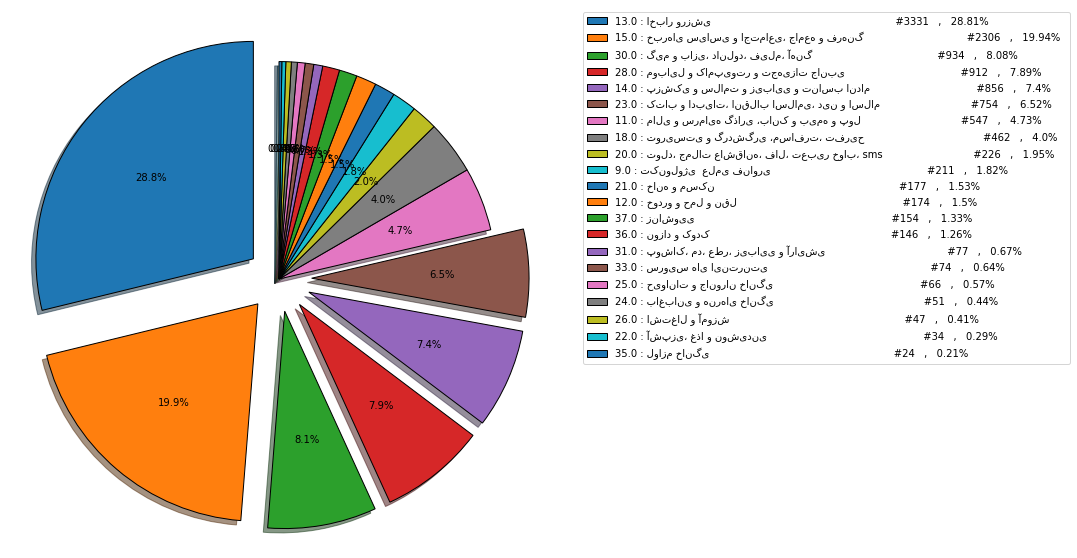

In [21]:
plt.figure(figsize=(10, 10))
plt.pie(values, labels=labels, autopct='%1.1f%%', explode = explodes,
        shadow=True, startangle=90,labeldistance = None, wedgeprops = {'edgecolor': 'black'})
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()

# Data Is Too Imbalanced...

# Dominant_probability distribution

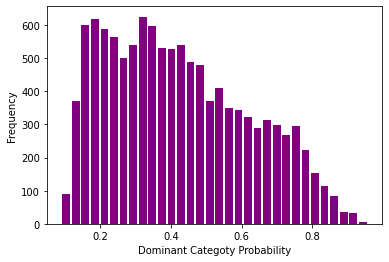

In [17]:
probs = df['dominant_category_prob']
plt.hist(probs,rwidth=0.8, bins = 'auto',color='purple')
plt.xlabel('Dominant Categoty Probability')
plt.ylabel('Frequency')
plt.show()

## test

In [22]:
tmp = df['text']

In [23]:
cleaned_texts = clean(tmp)

0.0 %  ^^
0.9945515869584018 %  ^^
1.9891031739168037 %  ^^
2.9836547608752055 %  ^^
3.9782063478336074 %  ^^
4.972757934792009 %  ^^
5.967309521750411 %  ^^
6.9618611087088125 %  ^^
7.956412695667215 %  ^^
8.950964282625616 %  ^^
9.945515869584018 %  ^^
10.940067456542419 %  ^^
11.934619043500822 %  ^^
12.929170630459224 %  ^^
13.923722217417625 %  ^^
14.918273804376026 %  ^^
15.91282539133443 %  ^^
16.90737697829283 %  ^^
17.901928565251232 %  ^^
18.896480152209634 %  ^^
19.891031739168035 %  ^^
20.885583326126437 %  ^^
21.880134913084838 %  ^^
22.874686500043243 %  ^^
23.869238087001644 %  ^^
24.863789673960046 %  ^^
25.858341260918447 %  ^^
26.85289284787685 %  ^^
27.84744443483525 %  ^^
28.84199602179365 %  ^^
29.836547608752053 %  ^^
30.831099195710454 %  ^^
31.82565078266886 %  ^^
32.82020236962726 %  ^^
33.81475395658566 %  ^^
34.80930554354406 %  ^^
35.803857130502465 %  ^^
36.798408717460866 %  ^^
37.79296030441927 %  ^^
38.78751189137767 %  ^^
39.78206347833607 %  ^^
40.7766

In [24]:
df['text'] = cleaned_texts
df.head(5)

,text,dominant_category_prob,dominant_name
0,سایت سامان قرن N همیشه فک خدا منو پیر کنعان یع...,0.174091,گیم و بازی، دانلود، فیلم، آهنگ
1,امیرحسین جون امیرمحمد جون امیرعلی جونم تولد مب...,0.274477,گیم و بازی، دانلود، فیلم، آهنگ
2,امیرحسین جون امیرمحمد جون امیرعلی جونم چهار شی...,0.198116,تولد، جملات عاشقانه، فال، تعبیر خواب، sms
3,امیرحسین جون امیرمحمد جون امیرعلی جونم نتیجه ا...,0.582283,گیم و بازی، دانلود، فیلم، آهنگ
4,امیرحسین جون امیرمحمد جون امیرعلی جونم پا امیر...,0.340593,تولد، جملات عاشقانه، فال، تعبیر خواب، sms


In [25]:
df = df[df['text'].apply(text_validation)]

In [29]:
test_df = pd.DataFrame(df)

In [30]:
test_df.head()

,text,dominant_category_prob,dominant_name
0,سایت سامان قرن N همیشه فک خدا منو پیر کنعان یع...,0.174091,گیم و بازی، دانلود، فیلم، آهنگ
1,امیرحسین جون امیرمحمد جون امیرعلی جونم تولد مب...,0.274477,گیم و بازی، دانلود، فیلم، آهنگ
2,امیرحسین جون امیرمحمد جون امیرعلی جونم چهار شی...,0.198116,تولد، جملات عاشقانه، فال، تعبیر خواب، sms
3,امیرحسین جون امیرمحمد جون امیرعلی جونم نتیجه ا...,0.582283,گیم و بازی، دانلود، فیلم، آهنگ
4,امیرحسین جون امیرمحمد جون امیرعلی جونم پا امیر...,0.340593,تولد، جملات عاشقانه، فال، تعبیر خواب، sms


## Reading Unlabled Data

In [31]:
wiki_data = None
with open('wiki.txt', 'r') as f:
    wiki_data = f.readlines()

wiki_data = clean(wiki_data)

0.0 %  ^^
0.575 %  ^^
1.15 %  ^^
1.725 %  ^^
2.3 %  ^^
2.875 %  ^^
3.45 %  ^^
4.025 %  ^^
4.6 %  ^^
5.175 %  ^^
5.75 %  ^^
6.325 %  ^^
6.9 %  ^^
7.475 %  ^^
8.05 %  ^^
8.625 %  ^^
9.2 %  ^^
9.775 %  ^^
10.35 %  ^^
10.925 %  ^^
11.5 %  ^^
12.075 %  ^^
12.65 %  ^^
13.225 %  ^^
13.8 %  ^^
14.375 %  ^^
14.95 %  ^^
15.525 %  ^^
16.1 %  ^^
16.675 %  ^^
17.25 %  ^^
17.825 %  ^^
18.4 %  ^^
18.975 %  ^^
19.55 %  ^^
20.125 %  ^^
20.7 %  ^^
21.275 %  ^^
21.85 %  ^^
22.425 %  ^^
23.0 %  ^^
23.575 %  ^^
24.15 %  ^^
24.725 %  ^^
25.3 %  ^^
25.875 %  ^^
26.45 %  ^^
27.025 %  ^^
27.6 %  ^^
28.175 %  ^^
28.75 %  ^^
29.325 %  ^^
29.9 %  ^^
30.475 %  ^^
31.05 %  ^^
31.625 %  ^^
32.2 %  ^^
32.775 %  ^^
33.35 %  ^^
33.925 %  ^^
34.5 %  ^^
35.075 %  ^^
35.65 %  ^^
36.225 %  ^^
36.8 %  ^^
37.375 %  ^^
37.95 %  ^^
38.525 %  ^^
39.1 %  ^^
39.675 %  ^^
40.25 %  ^^
40.825 %  ^^
41.4 %  ^^
41.975 %  ^^
42.55 %  ^^
43.125 %  ^^
43.7 %  ^^
44.275 %  ^^
44.85 %  ^^
45.425 %  ^^
46.0 %  ^^
46.575 %  ^^
47.15 %  ^^
47

## Implementation and Semi-Supervised Learning

In [33]:
wiki_data_copy = wiki_data[:]

### If you want to use resampling techniques, run these cells, o.w, continue without resampling

#### Using UnderSampling with The Datapoints that have the highest probability, Either Run This or the Below one.

In [200]:
label_list, min_value = list(dict(df['dominant_name'].value_counts()).keys()), min(list(dict(df['dominant_name'].value_counts()).values()))
label_list.reverse()
resampled_df = pd.DataFrame(columns = df.columns)
for label in label_list:
    tmp = df[df['dominant_name']==label]
    if tmp.shape[0]< min_value*1.5:
        resampled_df = pd.concat([resampled_df,tmp])
    else:
        topk_tmp = tmp.sort_values('dominant_category_prob', ascending = False).nlargest(int(1.5*min_value),'dominant_category_prob')
        resampled_df = pd.concat([resampled_df,topk_tmp])


#### Using UnderSampling with The Datapoints that have the highest probability

In [289]:
label_list, min_value = list(dict(df['dominant_name'].value_counts()).keys()), min(list(dict(df['dominant_name'].value_counts()).values()))
label_list.reverse()
resampled_df = pd.DataFrame(columns = df.columns)
for label in label_list:
    tmp = df[df['dominant_name']==label]
    if tmp.shape[0]< min_value*1.5:
        resampled_df = pd.concat([resampled_df,tmp],ignore_index = True)
    else:
        topk_tmp = tmp.sample(n = int(1.5*min_value))
        resampled_df = pd.concat([resampled_df,topk_tmp])

In [290]:
resampled_df

,text,dominant_category_prob,dominant_name
0,خبرگزاری فارس حکم دل تازه عروس داماد اصفهانی ش...,0.211997,لوازم خانگی
1,خبرگزاری فارس امادگی شرکت تولید لوازم خانگی اف...,0.544122,لوازم خانگی
2,خبرگزاری فارس کشف لوازم بهداشتی احتکار ارزش N ...,0.248455,لوازم خانگی
3,خبرگزاری فارس طرح فرو لوازم خانگی اجرا گزارش خ...,0.518505,لوازم خانگی
4,خبرگزاری فارس کوتوله شگفت انگیز خانه ایران گزا...,0.276037,لوازم خانگی
...,...,...,...
8493,ورزش مرجع بین المللی اطلاعات خبر ورزشی سراسر ج...,0.389439,اخبار ورزشی
8487,ویکتوریا پلژن ورزش باشگاه فوتبال ویکتوریا پلژن...,0.759818,اخبار ورزشی
11387,مشکل سیمیونه بارسا ورزش نقل اتلتیکومادرید شنبه...,0.729223,اخبار ورزشی
11327,مسی بارسا ترک کند ورزش گزارش ایسنا موندو دپورت...,0.872180,اخبار ورزشی


In [291]:
category_occurences, explodes, total_values = dict(resampled_df['dominant_name'].value_counts()), [0 for index in range(resampled_df['dominant_name'].unique().shape[0])], 0
labels, values = [categtoint[x]+ " : " + x for x in category_occurences.keys()], [x for x in category_occurences.values()]
for value in values:
    total_values += value
labels = [x + ' '*(75-len(x)) + '  #{}   ,   {}%  '.format(values[index],round(values[index]*100/total_values,2)) for index,x in enumerate(list(labels))]

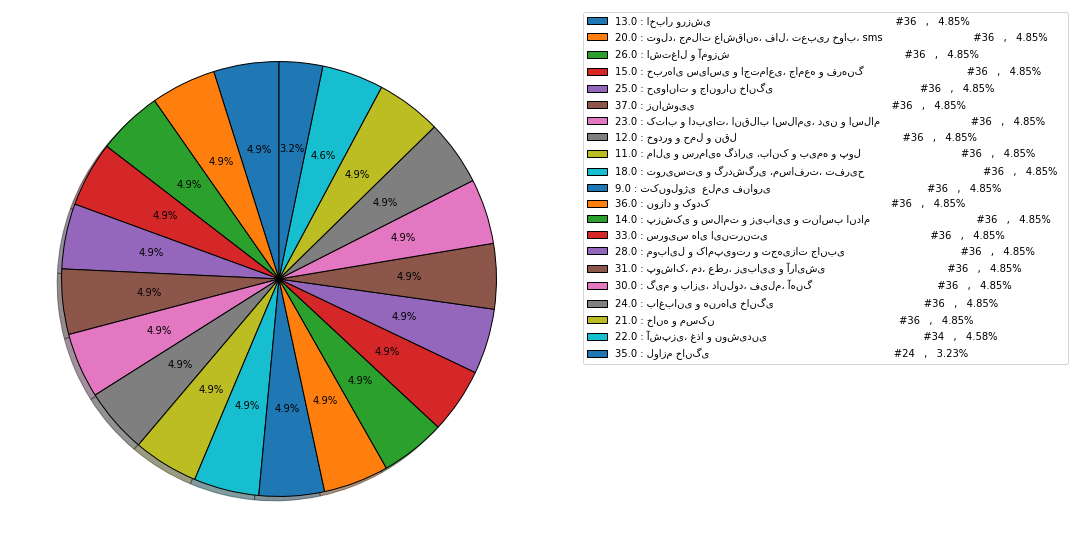

In [292]:
plt.figure(figsize=(10, 10))
plt.pie(values, labels=labels, autopct='%1.1f%%', explode = explodes,
        shadow=True, startangle=90,labeldistance = None, wedgeprops = {'edgecolor': 'black'})
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()

In [293]:
rX_train, rX_test,ry_train,ry_test = train_test_split(resampled_df['text'],resampled_df['dominant_name'], test_size = 0.2, random_state = 0)

In [294]:
models, vectorizers = [], []
for model_type in range(6):
    wiki_data_copy = wiki_data[:]
    threshold, new_df_rows_count, iterations = 0.7, [], 31
    for i in range(iterations):
        # Creating Vectorizer and Vectorizing the Train Data
        tmp, remaining_rows = set(), []
        text_vectorizer = TfidfVectorizer()
        vectorized_data = text_vectorizer.fit_transform(rX_train)

        # Creating The Machine Learning Model an Training
        clf = get_model(model_type).fit(vectorized_data, ry_train)

        # Predicting The Unlabled Data
        Unlabled_X = text_vectorizer.transform(wiki_data_copy)
        y_hat = clf.predict(Unlabled_X)
        y_hat_probs = clf.predict_proba(Unlabled_X)
        #Adding Psuedo-labels To Train Data
        for index,prob in enumerate(y_hat_probs):
            if max(prob) > threshold:
                tmp.add(index)
                rX_train.append(pd.Series(wiki_data_copy[index]), ignore_index = True)
                ry_train.append(pd.Series(y_hat[index]), ignore_index = True)
        #Removing The Psuedo-label data from Unlabled
        for index, doc in enumerate(wiki_data_copy):
            if index not in tmp:
                remaining_rows.append(doc)
        wiki_data_copy = remaining_rows[:]
        new_df_rows_count.append(len(tmp))

        # Testing The Model On Dataset
        vectorized_test = text_vectorizer.transform(rX_test)
        y_pred = clf.predict(vectorized_test)
        if i == iterations-1 or len(tmp) == 0 or len(wiki_data_copy)==0:
            y1,y2 = [categtoint[x] for x in ry_test],[categtoint[x] for x in y_pred]
            print(classification_report(y1, y2))
            print('Model Number {}, iteration {}, rows_added {}, F1_Score = {}'.format(inttomodel[model_type],i+1,sum(new_df_rows_count),f1_score(ry_test, y_pred, zero_division=1, average = 'macro')))
            models.append(clf)
            vectorizers.append(text_vectorizer)
            print("*********************************************************")
            break

              precision    recall  f1-score   support

        11.0       0.89      0.57      0.70        14
        12.0       0.67      0.67      0.67         6
        13.0       0.50      1.00      0.67         6
        14.0       0.80      0.57      0.67         7
        15.0       0.50      0.88      0.64         8
        18.0       0.25      0.17      0.20         6
        20.0       0.22      0.50      0.31         4
        21.0       0.75      0.67      0.71         9
        22.0       1.00      0.67      0.80         9
        23.0       0.38      0.60      0.46         5
        24.0       0.29      0.40      0.33         5
        25.0       0.30      0.75      0.43         4
        26.0       1.00      0.83      0.91         6
        28.0       0.20      0.14      0.17         7
        30.0       1.00      0.36      0.53        11
        31.0       0.67      0.57      0.62         7
        33.0       0.44      0.57      0.50         7
        35.0       0.67    

/Users/mehrad/interviews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mehrad/interviews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mehrad/interviews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Best Results of Random Samples with Threshold 65%
## ============================================
precision    recall  f1-score   support

        11.0       0.78      0.88      0.82         8
        12.0       0.78      0.88      0.82         8
        13.0       0.90      0.90      0.90        10
        14.0       1.00      0.53      0.69        17
        15.0       0.80      0.80      0.80        10
        18.0       0.44      0.36      0.40        11
        20.0       0.21      0.67      0.32         6
        21.0       0.80      0.89      0.84         9
        22.0       0.83      0.71      0.77         7
        23.0       0.71      0.45      0.56        11
        24.0       0.60      0.67      0.63         9
        25.0       0.40      0.67      0.50         3
        26.0       0.67      0.80      0.73         5
        28.0       0.38      0.67      0.48         9
        30.0       0.75      0.67      0.71         9
        31.0       0.86      0.75      0.80        16
        33.0       0.75      0.86      0.80         7
        35.0       0.00      0.00      0.00         4
        36.0       0.62      0.45      0.53        11
        37.0       0.56      0.69      0.62        13
         9.0       0.80      0.36      0.50        11

    accuracy                           0.65       194
   macro avg       0.65      0.65      0.63       194
weighted avg       0.70      0.65      0.65       194

Model Number SVC, iteration 18, rows_added 3113, F1_Score = 0.6294284560004642
*********************************************************
              precision    recall  f1-score   support

        11.0       0.89      1.00      0.94         8
        12.0       0.88      0.88      0.88         8
        13.0       0.75      0.90      0.82        10
        14.0       1.00      0.47      0.64        17
        15.0       0.73      0.80      0.76        10
        18.0       0.57      0.36      0.44        11
        20.0       0.27      0.50      0.35         6
        21.0       0.73      0.89      0.80         9
        22.0       0.60      0.86      0.71         7
        23.0       0.86      0.55      0.67        11
        24.0       0.67      0.67      0.67         9
        25.0       0.50      1.00      0.67         3
        26.0       0.36      0.80      0.50         5
        28.0       0.38      0.56      0.45         9
        30.0       0.86      0.67      0.75         9
        31.0       0.86      0.75      0.80        16
        33.0       0.86      0.86      0.86         7
        35.0       1.00      0.25      0.40         4
        36.0       0.73      0.73      0.73        11
        37.0       0.56      0.69      0.62        13
         9.0       0.80      0.36      0.50        11

    accuracy                           0.68       194
   macro avg       0.71      0.69      0.66       194
weighted avg       0.73      0.68      0.68       194

Model Number SGD, iteration 22, rows_added 2385, F1_Score = 0.6642467485078323

## =========================================

## Best Results with datapoints with high probability
# =======================================

precision    recall  f1-score   support

        11.0       1.00      1.00      1.00        14
        12.0       1.00      1.00      1.00         6
        13.0       0.86      1.00      0.92         6
        14.0       0.78      1.00      0.88         7
        15.0       1.00      1.00      1.00         8
        18.0       1.00      0.67      0.80         6
        20.0       0.60      0.75      0.67         4
        21.0       1.00      0.89      0.94         9
        22.0       1.00      0.56      0.71         9
        23.0       0.83      1.00      0.91         5
        24.0       0.60      0.60      0.60         5
        25.0       0.67      1.00      0.80         4
        26.0       0.75      1.00      0.86         6
        28.0       0.88      1.00      0.93         7
        30.0       0.82      0.82      0.82        11
        31.0       1.00      1.00      1.00         7
        33.0       1.00      0.86      0.92         7
        35.0       1.00      0.40      0.57         5
        36.0       0.82      0.90      0.86        10
        37.0       0.83      0.83      0.83         6
         9.0       1.00      1.00      1.00         7

    accuracy                           0.88       149
   macro avg       0.88      0.87      0.86       149
weighted avg       0.90      0.88      0.87       149

Model Number logistic Regression, iteration 1, rows_added 0, F1_Score = 0.8582350655880068
*********************************************************
              precision    recall  f1-score   support

        11.0       1.00      1.00      1.00        14
        12.0       1.00      1.00      1.00         6
        13.0       0.83      0.83      0.83         6
        14.0       1.00      1.00      1.00         7
        15.0       1.00      1.00      1.00         8
        18.0       1.00      0.67      0.80         6
        20.0       0.50      0.75      0.60         4
        21.0       1.00      0.78      0.88         9
        22.0       0.89      0.89      0.89         9
        23.0       1.00      1.00      1.00         5
        24.0       0.60      0.60      0.60         5
        25.0       0.80      1.00      0.89         4
        26.0       0.60      1.00      0.75         6
        28.0       0.88      1.00      0.93         7
        30.0       1.00      0.91      0.95        11
        31.0       1.00      1.00      1.00         7
        33.0       0.86      0.86      0.86         7
        35.0       1.00      0.40      0.57         5
        36.0       0.82      0.90      0.86        10
        37.0       1.00      0.83      0.91         6
         9.0       1.00      1.00      1.00         7

    accuracy                           0.89       149
   macro avg       0.89      0.88      0.87       149
weighted avg       0.91      0.89      0.89       149

Model Number SVC, iteration 13, rows_added 1839, F1_Score = 0.8722205043633615
*********************************************************
              precision    recall  f1-score   support

        11.0       1.00      1.00      1.00        14
        12.0       1.00      1.00      1.00         6
        13.0       0.86      1.00      0.92         6
        14.0       1.00      1.00      1.00         7
        15.0       1.00      1.00      1.00         8
        18.0       1.00      0.50      0.67         6
        20.0       0.75      0.75      0.75         4
        21.0       1.00      0.89      0.94         9
        22.0       1.00      0.78      0.88         9
        23.0       1.00      1.00      1.00         5
        24.0       0.60      0.60      0.60         5
        25.0       0.67      1.00      0.80         4
        26.0       0.75      1.00      0.86         6
        28.0       0.88      1.00      0.93         7
        30.0       0.82      0.82      0.82        11
        31.0       1.00      1.00      1.00         7
        33.0       0.75      0.86      0.80         7
        35.0       1.00      0.40      0.57         5
        36.0       0.77      1.00      0.87        10
        37.0       0.83      0.83      0.83         6
         9.0       1.00      0.86      0.92         7

    accuracy                           0.89       149
   macro avg       0.89      0.87      0.86       149
weighted avg       0.90      0.89      0.88       149

Model Number SGD, iteration 27, rows_added 2145, F1_Score = 0.8648562911533316
*********************************************************
              precision    recall  f1-score   support

        11.0       1.00      0.57      0.73        14
        12.0       1.00      1.00      1.00         6
        13.0       0.75      0.50      0.60         6
        14.0       0.88      1.00      0.93         7
        15.0       0.80      1.00      0.89         8
        18.0       0.67      0.33      0.44         6
        20.0       0.08      0.25      0.12         4
        21.0       0.86      0.67      0.75         9
        22.0       0.12      0.11      0.12         9
        23.0       0.43      0.60      0.50         5
        24.0       0.20      0.40      0.27         5
        25.0       0.50      0.75      0.60         4
        26.0       0.33      0.33      0.33         6
        28.0       0.70      1.00      0.82         7
        30.0       0.62      0.45      0.53        11
        31.0       0.80      0.57      0.67         7
        33.0       0.62      0.71      0.67         7
        35.0       0.67      0.40      0.50         5
        36.0       0.50      0.40      0.44        10
        37.0       1.00      0.83      0.91         6
         9.0       1.00      0.86      0.92         7

    accuracy                           0.60       149
   macro avg       0.64      0.61      0.61       149
weighted avg       0.67      0.60      0.62       149

Model Number Decision Tree, iteration 1, rows_added 20000, F1_Score = 0.6066202058462121
*********************************************************
              precision    recall  f1-score   support

        11.0       1.00      1.00      1.00        14
        12.0       0.86      1.00      0.92         6
        13.0       0.71      0.83      0.77         6
        14.0       0.88      1.00      0.93         7
        15.0       0.53      1.00      0.70         8
        18.0       0.80      0.67      0.73         6
        20.0       0.43      0.75      0.55         4
        21.0       0.80      0.89      0.84         9
        22.0       0.83      0.56      0.67         9
        23.0       0.80      0.80      0.80         5
        24.0       0.50      0.40      0.44         5
        25.0       0.50      1.00      0.67         4
        26.0       0.67      0.67      0.67         6
        28.0       0.70      1.00      0.82         7
        30.0       1.00      0.36      0.53        11
        31.0       1.00      1.00      1.00         7
        33.0       0.80      0.57      0.67         7
        35.0       0.00      0.00      0.00         5
        36.0       0.71      0.50      0.59        10
        37.0       1.00      0.83      0.91         6
         9.0       0.88      1.00      0.93         7

    accuracy                           0.76       149
   macro avg       0.73      0.75      0.72       149
weighted avg       0.77      0.76      0.74       149

Model Number Random Forest, iteration 4, rows_added 5, F1_Score = 0.7207028156281085
*********************************************************
              precision    recall  f1-score   support

        11.0       1.00      1.00      1.00        14
        12.0       0.67      1.00      0.80         6
        13.0       0.67      1.00      0.80         6
        14.0       0.88      1.00      0.93         7
        15.0       0.89      1.00      0.94         8
        18.0       1.00      0.50      0.67         6
        20.0       0.60      0.75      0.67         4
        21.0       1.00      0.89      0.94         9
        22.0       1.00      0.11      0.20         9
        23.0       1.00      1.00      1.00         5
        24.0       0.40      0.40      0.40         5
        25.0       0.40      1.00      0.57         4
        26.0       0.75      1.00      0.86         6
        28.0       0.88      1.00      0.93         7
        30.0       1.00      0.64      0.78        11
        31.0       0.78      1.00      0.88         7
        33.0       1.00      0.86      0.92         7
        35.0       0.00      0.00      0.00         5
        36.0       0.83      1.00      0.91        10
        37.0       0.83      0.83      0.83         6
         9.0       1.00      1.00      1.00         7

    accuracy                           0.82       149
   macro avg       0.79      0.81      0.76       149
weighted avg       0.84      0.82      0.79       149

Model Number Naive Bayes, iteration 1, rows_added 0, F1_Score = 0.763295395858421
*********************************************************

# Best Results of theshold 0.7

precision    recall  f1-score   support

        11.0       1.00      1.00      1.00        14
        12.0       1.00      1.00      1.00         6
        13.0       0.83      0.83      0.83         6
        14.0       1.00      1.00      1.00         7
        15.0       1.00      1.00      1.00         8
        18.0       1.00      0.67      0.80         6
        20.0       0.50      0.75      0.60         4
        21.0       1.00      0.78      0.88         9
        22.0       0.89      0.89      0.89         9
        23.0       1.00      1.00      1.00         5
        24.0       0.60      0.60      0.60         5
        25.0       0.80      1.00      0.89         4
        26.0       0.60      1.00      0.75         6
        28.0       0.88      1.00      0.93         7
        30.0       1.00      0.91      0.95        11
        31.0       1.00      1.00      1.00         7
        33.0       0.86      0.86      0.86         7
        35.0       1.00      0.40      0.57         5
        36.0       0.82      0.90      0.86        10
        37.0       1.00      0.83      0.91         6
         9.0       1.00      1.00      1.00         7

    accuracy                           0.89       149
   macro avg       0.89      0.88      0.87       149
weighted avg       0.91      0.89      0.89       149

Model Number SVC, iteration 14, rows_added 1494, F1_Score = 0.8722205043633615
*********************************************************
              precision    recall  f1-score   support

        11.0       1.00      1.00      1.00        14
        12.0       1.00      1.00      1.00         6
        13.0       0.86      1.00      0.92         6
        14.0       1.00      1.00      1.00         7
        15.0       1.00      1.00      1.00         8
        18.0       1.00      0.67      0.80         6
        20.0       0.75      0.75      0.75         4
        21.0       1.00      0.89      0.94         9
        22.0       1.00      0.89      0.94         9
        23.0       1.00      1.00      1.00         5
        24.0       0.50      0.60      0.55         5
        25.0       0.80      1.00      0.89         4
        26.0       0.75      1.00      0.86         6
        28.0       0.88      1.00      0.93         7
        30.0       0.80      0.73      0.76        11
        31.0       1.00      1.00      1.00         7
        33.0       0.75      0.86      0.80         7
        35.0       1.00      0.40      0.57         5
        36.0       0.83      1.00      0.91        10
        37.0       0.83      0.83      0.83         6
         9.0       1.00      0.86      0.92         7

    accuracy                           0.89       149
   macro avg       0.89      0.88      0.88       149
weighted avg       0.91      0.89      0.89       149

Model Number SGD, iteration 11, rows_added 1512, F1_Score = 0.8751944756146437

===========================================
# Results with threshold 0.8 
==========================
precision    recall  f1-score   support

        11.0       1.00      1.00      1.00         5
        12.0       1.00      1.00      1.00        10
        13.0       0.67      1.00      0.80         6
        14.0       0.86      1.00      0.92         6
        15.0       1.00      1.00      1.00         6
        18.0       0.67      0.86      0.75         7
        20.0       1.00      0.22      0.36         9
        21.0       1.00      1.00      1.00         8
        22.0       0.86      0.75      0.80         8
        23.0       0.67      0.67      0.67         6
        24.0       0.50      0.40      0.44         5
        25.0       0.88      1.00      0.93         7
        26.0       1.00      0.47      0.64        15
        28.0       0.62      1.00      0.77         5
        30.0       0.75      0.86      0.80         7
        31.0       1.00      1.00      1.00        10
        33.0       0.36      0.80      0.50         5
        35.0       0.50      0.67      0.57         3
        36.0       0.78      0.88      0.82         8
        37.0       0.80      0.80      0.80         5
         9.0       1.00      0.75      0.86         8

    accuracy                           0.80       149
   macro avg       0.81      0.81      0.78       149
weighted avg       0.85      0.80      0.79       149

Model Number logistic Regression, iteration 1, rows_added 0, F1_Score = 0.782802522718489
*********************************************************
              precision    recall  f1-score   support

        11.0       1.00      1.00      1.00         5
        12.0       1.00      1.00      1.00        10
        13.0       0.86      1.00      0.92         6
        14.0       0.86      1.00      0.92         6
        15.0       1.00      1.00      1.00         6
        18.0       0.55      0.86      0.67         7
        20.0       1.00      0.44      0.62         9
        21.0       1.00      1.00      1.00         8
        22.0       0.88      0.88      0.88         8
        23.0       0.67      0.67      0.67         6
        24.0       0.22      0.40      0.29         5
        25.0       1.00      0.71      0.83         7
        26.0       1.00      0.73      0.85        15
        28.0       0.83      1.00      0.91         5
        30.0       0.86      0.86      0.86         7
        31.0       1.00      0.90      0.95        10
        33.0       0.62      1.00      0.77         5
        35.0       0.60      1.00      0.75         3
        36.0       0.86      0.75      0.80         8
        37.0       1.00      0.80      0.89         5
         9.0       1.00      0.75      0.86         8

    accuracy                           0.83       149
   macro avg       0.85      0.85      0.83       149
weighted avg       0.88      0.83      0.84       149

Model Number SVC, iteration 10, rows_added 640, F1_Score = 0.8292351410772464
*********************************************************
              precision    recall  f1-score   support

        11.0       1.00      1.00      1.00         5
        12.0       1.00      1.00      1.00        10
        13.0       1.00      1.00      1.00         6
        14.0       0.86      1.00      0.92         6
        15.0       1.00      1.00      1.00         6
        18.0       0.67      0.86      0.75         7
        20.0       1.00      0.22      0.36         9
        21.0       1.00      1.00      1.00         8
        22.0       0.73      1.00      0.84         8
        23.0       0.60      0.50      0.55         6
        24.0       0.50      0.40      0.44         5
        25.0       0.83      0.71      0.77         7
        26.0       1.00      0.67      0.80        15
        28.0       0.71      1.00      0.83         5
        30.0       0.60      0.86      0.71         7
        31.0       0.91      1.00      0.95        10
        33.0       0.50      1.00      0.67         5
        35.0       0.50      0.67      0.57         3
        36.0       0.88      0.88      0.88         8
        37.0       1.00      0.80      0.89         5
         9.0       1.00      0.75      0.86         8

    accuracy                           0.82       149
   macro avg       0.82      0.82      0.80       149
weighted avg       0.86      0.82      0.81       149

Model Number SGD, iteration 16, rows_added 708, F1_Score = 0.7994605681801614
*********************************************************
              precision    recall  f1-score   support

        11.0       1.00      0.80      0.89         5
        12.0       1.00      1.00      1.00        10
        13.0       0.71      0.83      0.77         6
        14.0       0.67      1.00      0.80         6
        15.0       0.75      1.00      0.86         6
        18.0       0.50      0.71      0.59         7
        20.0       0.50      0.22      0.31         9
        21.0       1.00      1.00      1.00         8
        22.0       0.50      0.50      0.50         8
        23.0       0.67      0.33      0.44         6
        24.0       0.50      0.40      0.44         5
        25.0       0.80      0.57      0.67         7
        26.0       0.88      0.47      0.61        15
        28.0       0.60      0.60      0.60         5
        30.0       0.44      0.57      0.50         7
        31.0       0.78      0.70      0.74        10
        33.0       0.33      0.60      0.43         5
        35.0       0.20      0.33      0.25         3
        36.0       0.75      0.75      0.75         8
        37.0       0.80      0.80      0.80         5
         9.0       0.27      0.38      0.32         8

    accuracy                           0.64       149
   macro avg       0.65      0.65      0.63       149
weighted avg       0.68      0.64      0.64       149

Model Number Decision Tree, iteration 1, rows_added 20000, F1_Score = 0.6312687777295588
*********************************************************
              precision    recall  f1-score   support

        11.0       0.83      1.00      0.91         5
        12.0       0.89      0.80      0.84        10
        13.0       0.67      1.00      0.80         6
        14.0       0.75      1.00      0.86         6
        15.0       0.75      1.00      0.86         6
        18.0       0.50      0.57      0.53         7
        20.0       0.60      0.33      0.43         9
        21.0       0.73      1.00      0.84         8
        22.0       0.50      0.25      0.33         8
        23.0       1.00      0.67      0.80         6
        24.0       0.33      0.40      0.36         5
        25.0       0.71      0.71      0.71         7
        26.0       0.80      0.53      0.64        15
        28.0       0.67      0.80      0.73         5
        30.0       1.00      0.57      0.73         7
        31.0       1.00      0.90      0.95        10
        33.0       0.38      0.60      0.46         5
        35.0       0.50      0.33      0.40         3
        36.0       0.67      0.75      0.71         8
        37.0       1.00      0.80      0.89         5
         9.0       0.67      1.00      0.80         8

    accuracy                           0.71       149
   macro avg       0.71      0.72      0.69       149
weighted avg       0.73      0.71      0.70       149

Model Number Random Forest, iteration 1, rows_added 0, F1_Score = 0.6942367096104382
*********************************************************
              precision    recall  f1-score   support

        11.0       0.56      1.00      0.71         5
        12.0       1.00      0.90      0.95        10
        13.0       0.50      1.00      0.67         6
        14.0       0.86      1.00      0.92         6
        15.0       0.75      1.00      0.86         6
        18.0       0.83      0.71      0.77         7
        20.0       1.00      0.22      0.36         9
        21.0       0.89      1.00      0.94         8
        22.0       0.80      0.50      0.62         8
        23.0       0.80      0.67      0.73         6
        24.0       0.29      0.40      0.33         5
        25.0       0.78      1.00      0.88         7
        26.0       1.00      0.33      0.50        15
        28.0       0.67      0.80      0.73         5
        30.0       0.80      0.57      0.67         7
        31.0       0.91      1.00      0.95        10
        33.0       0.31      0.80      0.44         5
        35.0       0.00      0.00      0.00         3
        36.0       0.75      0.75      0.75         8
        37.0       0.80      0.80      0.80         5
         9.0       0.86      0.75      0.80         8

    accuracy                           0.72       149
   macro avg       0.72      0.72      0.68       149
weighted avg       0.78      0.72      0.70       149

Model Number Naive Bayes, iteration 1, rows_added 0, F1_Score = 0.6844923644016965
*********************************************************

In [212]:
with open('best_resample_SVM_07.pickle','wb') as f:
    pickle.dump(models[1],f)
with open('best_SVC.pickle','wb') as f:
    pickle.dump(models[1],f)
with open('best_vectorizer.pickle','wb') as f:
    pickle.dump(vectorizers[1],f)

In [213]:
with open('best_SGD.pickle','wb') as f:
    pickle.dump(models[2],f)
with open('best_SGD_vectorizer.pickle','wb') as f:
    pickle.dump(vectorizers[2],f)

## Semi-Supervised Without Oversampling and undersampling

In [167]:
valid_data = df[df['dominant_category_prob'] > 0.5]

In [168]:
category_occurences, explodes, total_values = dict(valid_data['dominant_name'].value_counts()), [0.15 if index <6 else 0 for index in range(valid_data['dominant_name'].unique().shape[0])], 0
labels, values = [categtoint[x]+ " : " + x for x in category_occurences.keys()], [x for x in category_occurences.values()]
for value in values:
    total_values += value
labels = [x + ' '*(75-len(x)) + '  #{}   ,   {}%  '.format(values[index],round(values[index]*100/total_values,2)) for index,x in enumerate(list(labels))]

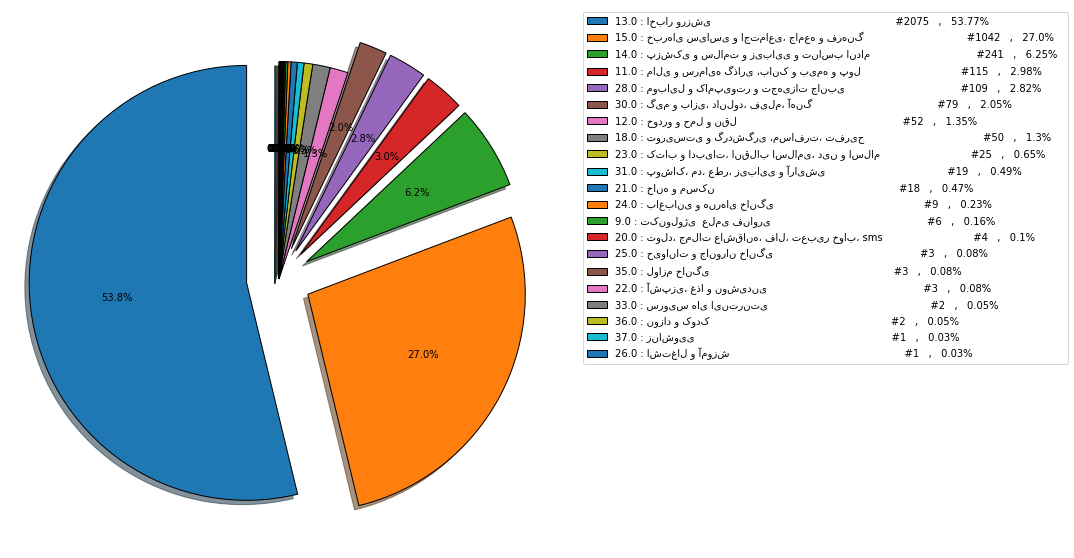

In [169]:
plt.figure(figsize=(10, 10))
plt.pie(values, labels=labels, autopct='%1.1f%%', explode = explodes,
        shadow=True, startangle=90,labeldistance = None, wedgeprops = {'edgecolor': 'black'})
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()

In [192]:
prob_threshold = 0.0
valid_data = df[df['dominant_category_prob'] > prob_threshold]

In [193]:
tmp_models = []
X_train, X_test, y_train, y_test = train_test_split(valid_data['text'],valid_data['dominant_name'], test_size = 0.2, random_state = 42)
for model_type in range(6):
    wiki_data_copy = wiki_data[:]
    valid_data = df[df['dominant_category_prob'] > prob_threshold]
    threshold, new_df_rows_count, iterations = 0.9, [], 31
    for i in range(iterations):
        # Creating Vectorizer and Vectorizing the Train Data
        tmp, remaining_rows = set(), []
        text_vectorizer = TfidfVectorizer()
        vectorized_data = text_vectorizer.fit_transform(X_train)

        # Creating The Machine Learning Model an Training
        clf = get_model(model_type).fit(vectorized_data, y_train)

        # Predicting The Unlabled Data
        Unlabled_X = text_vectorizer.transform(wiki_data_copy)
        y_hat = clf.predict(Unlabled_X)
        y_hat_probs = clf.predict_proba(Unlabled_X)
        #Adding Psuedo-labels To Train Data
        for index,prob in enumerate(y_hat_probs):
            if max(prob) > threshold:
                tmp.add(index)
                X_train.append(pd.Series(wiki_data_copy[index]), ignore_index = True)
                y_train.append(pd.Series(y_hat[index]), ignore_index = True)
        #Removing The Psuedo-label data from Unlabled
        for index, doc in enumerate(wiki_data_copy):
            if index not in tmp:
                remaining_rows.append(doc)
        wiki_data_copy = remaining_rows[:]
        new_df_rows_count.append(len(tmp))

        # Testing The Model On Dataset
        vectorized_test = text_vectorizer.transform(X_test)
        y_pred = clf.predict(vectorized_test)
        if i == iterations-1 or len(tmp) == 0 or len(wiki_data_copy) == 0:
            print('Model Number {}, iteration {}, F1_Score = {}'.format(inttomodel[model_type],i+1,f1_score(y_test, y_pred, zero_division=1, average = 'macro')))
            print("*********************************************************")
            y1,y2 = [categtoint[x] for x in y_test],[categtoint[x] for x in y_pred]
            print(classification_report(y1, y2))
            tmp_models.append(clf)
            break


Model Number logistic Regression, iteration 2, F1_Score = 0.43699301613436703
*********************************************************
              precision    recall  f1-score   support

        11.0       0.86      0.72      0.78       108
        12.0       0.91      0.58      0.71        36
        13.0       0.90      0.97      0.93       627
        14.0       0.73      0.80      0.76       169
        15.0       0.83      0.95      0.89       499
        18.0       0.70      0.60      0.64        97
        20.0       0.86      0.16      0.27        37
        21.0       0.76      0.52      0.62        31
        22.0       0.00      0.00      0.00        12
        23.0       0.67      0.74      0.70       137
        24.0       0.00      0.00      0.00         8
        25.0       0.00      0.00      0.00        12
        26.0       0.00      0.00      0.00         8
        28.0       0.59      0.83      0.69       186
        30.0       0.66      0.65      0.66       198

/Users/mehrad/interviews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mehrad/interviews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mehrad/interviews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model Number SVC, iteration 10, F1_Score = 0.596556375814737
*********************************************************
              precision    recall  f1-score   support

        11.0       0.83      0.83      0.83       108
        12.0       0.77      0.83      0.80        36
        13.0       0.94      0.94      0.94       627
        14.0       0.74      0.82      0.78       169
        15.0       0.92      0.88      0.90       499
        18.0       0.70      0.71      0.71        97
        20.0       0.37      0.41      0.38        37
        21.0       0.57      0.68      0.62        31
        22.0       1.00      0.25      0.40        12
        23.0       0.71      0.80      0.75       137
        24.0       0.40      0.25      0.31         8
        25.0       0.78      0.58      0.67        12
        26.0       0.43      0.38      0.40         8
        28.0       0.65      0.72      0.68       186
        30.0       0.69      0.62      0.65       198
        31.0    

/Users/mehrad/interviews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mehrad/interviews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mehrad/interviews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model Number SGD, iteration 5, F1_Score = 0.5447357236947836
*********************************************************
              precision    recall  f1-score   support

        11.0       0.81      0.73      0.77       108
        12.0       0.65      0.86      0.74        36
        13.0       0.93      0.92      0.92       627
        14.0       0.72      0.75      0.73       169
        15.0       0.90      0.86      0.88       499
        18.0       0.63      0.61      0.62        97
        20.0       0.27      0.32      0.29        37
        21.0       0.38      0.65      0.48        31
        22.0       0.50      0.42      0.45        12
        23.0       0.65      0.68      0.67       137
        24.0       0.22      0.50      0.31         8
        25.0       0.50      0.75      0.60        12
        26.0       0.24      0.62      0.34         8
        28.0       0.65      0.62      0.64       186
        30.0       0.80      0.53      0.63       198
        31.0    

/Users/mehrad/interviews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mehrad/interviews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mehrad/interviews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model Number Naive Bayes, iteration 2, F1_Score = 0.1713076028487362
*********************************************************
              precision    recall  f1-score   support

        11.0       1.00      0.09      0.17       108
        12.0       0.00      0.00      0.00        36
        13.0       0.72      1.00      0.83       627
        14.0       0.95      0.23      0.37       169
        15.0       0.47      0.98      0.64       499
        18.0       0.00      0.00      0.00        97
        20.0       0.00      0.00      0.00        37
        21.0       0.00      0.00      0.00        31
        22.0       0.00      0.00      0.00        12
        23.0       0.77      0.25      0.38       137
        24.0       0.00      0.00      0.00         8
        25.0       0.00      0.00      0.00        12
        26.0       0.00      0.00      0.00         8
        28.0       0.75      0.65      0.69       186
        30.0       0.62      0.44      0.52       198
        

/Users/mehrad/interviews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mehrad/interviews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mehrad/interviews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [172]:
with open('SVM-NoResample.pickle', 'wb') as f:
    pickle.dump(tmp_models[1], f)

### Threshold 0.7 best result, some of the classes doesnt have any data_points

Model Number SVC, iteration 9, F1_Score = 0.8051254224708974
*********************************************************
              precision    recall  f1-score   support

        11.0       0.75      1.00      0.86         3
        12.0       1.00      0.50      0.67         2
        13.0       0.98      0.98      0.98       166
        14.0       0.89      1.00      0.94        25
        15.0       0.98      1.00      0.99        61
        18.0       0.00      0.00      0.00         4
        21.0       1.00      1.00      1.00         5
        28.0       1.00      1.00      1.00         7

    accuracy                           0.97       273
   macro avg       0.83      0.81      0.81       273
weighted avg       0.96      0.97      0.96       273


### testing the model without semi-supervised and any filtering

In [183]:
X_train, X_test, y_train, y_test = train_test_split(df['text'],df['dominant_name'], test_size = 0.2, random_state = 42)

In [184]:
new_vectorizer = TfidfVectorizer()
vectors = new_vectorizer.fit_transform(X_train)

In [186]:
new_clf = get_model(1).fit(vectors, y_train)

In [188]:
test_vectors = new_vectorizer.transform(X_test)

In [189]:
y_preds = new_clf.predict(test_vectors)

In [191]:
y1,y2 = [categtoint[x] for x in y_test],[categtoint[x] for x in y_preds]
print(classification_report(y1, y2))

              precision    recall  f1-score   support

        11.0       0.83      0.83      0.83       108
        12.0       0.77      0.83      0.80        36
        13.0       0.94      0.94      0.94       627
        14.0       0.74      0.82      0.78       169
        15.0       0.92      0.88      0.90       499
        18.0       0.70      0.71      0.71        97
        20.0       0.37      0.41      0.38        37
        21.0       0.57      0.68      0.62        31
        22.0       1.00      0.25      0.40        12
        23.0       0.71      0.80      0.75       137
        24.0       0.40      0.25      0.31         8
        25.0       0.78      0.58      0.67        12
        26.0       0.43      0.38      0.40         8
        28.0       0.65      0.72      0.68       186
        30.0       0.69      0.62      0.65       198
        31.0       0.71      0.56      0.63         9
        33.0       0.80      0.40      0.53        20
        35.0       0.00    

/Users/mehrad/interviews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mehrad/interviews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mehrad/interviews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Training With Feature Selection

In [214]:
all_data, all_labels = df['text'], df['dominant_name']

In [215]:
tf_idf_vectorizer = TfidfVectorizer()
vectorized_data = tf_idf_vectorizer.fit_transform(all_data)

In [216]:
vectorized_data.shape

(11513, 79073)

In [221]:
chi2_selector = SelectKBest(chi2, k=5000)
best_features_data = chi2_selector.fit_transform(vectorized_data, all_labels)

In [222]:
kX_train, kX_test, ky_train, ky_test = train_test_split(best_features_data, all_labels, test_size = 0.2, random_state = 42)

In [223]:
#Training a SVC Model.
kModel = get_model(1).fit(kX_train,ky_train)

In [225]:
ky_hat = kModel.predict(kX_test)

In [230]:
ky1,ky2 = [categtoint[x] for x in ky_test],[categtoint[x] for x in ky_hat]
print(classification_report(ky1, ky2))

              precision    recall  f1-score   support

        11.0       0.80      0.84      0.82       108
        12.0       0.75      0.83      0.79        36
        13.0       0.93      0.93      0.93       627
        14.0       0.74      0.82      0.78       169
        15.0       0.94      0.84      0.89       499
        18.0       0.65      0.76      0.70        97
        20.0       0.33      0.43      0.37        37
        21.0       0.51      0.68      0.58        31
        22.0       1.00      0.25      0.40        12
        23.0       0.70      0.82      0.76       137
        24.0       0.40      0.25      0.31         8
        25.0       0.78      0.58      0.67        12
        26.0       0.43      0.38      0.40         8
        28.0       0.70      0.69      0.69       186
        30.0       0.70      0.64      0.66       198
        31.0       0.71      0.56      0.63         9
        33.0       0.80      0.40      0.53        20
        35.0       0.00    

/Users/mehrad/interviews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mehrad/interviews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mehrad/interviews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [231]:
chi2_selector = SelectKBest(chi2, k=10000)
best_features_data = chi2_selector.fit_transform(vectorized_data, all_labels)

In [232]:
kX_train, kX_test, ky_train, ky_test = train_test_split(best_features_data, all_labels, test_size = 0.2, random_state = 42)

In [233]:
#Training a SVC Model.
k2Model = get_model(1).fit(kX_train,ky_train)

In [234]:
k2yhat = k2Model.predict(kX_test)

In [236]:
ky1,ky2 = [categtoint[x] for x in ky_test],[categtoint[x] for x in k2yhat]
print(classification_report(ky1, ky2))

              precision    recall  f1-score   support

        11.0       0.84      0.83      0.84       108
        12.0       0.86      0.83      0.85        36
        13.0       0.93      0.93      0.93       627
        14.0       0.74      0.82      0.78       169
        15.0       0.93      0.87      0.90       499
        18.0       0.68      0.74      0.71        97
        20.0       0.36      0.41      0.38        37
        21.0       0.55      0.68      0.61        31
        22.0       1.00      0.25      0.40        12
        23.0       0.69      0.81      0.75       137
        24.0       0.40      0.25      0.31         8
        25.0       0.78      0.58      0.67        12
        26.0       0.50      0.38      0.43         8
        28.0       0.68      0.70      0.69       186
        30.0       0.69      0.63      0.65       198
        31.0       0.71      0.56      0.63         9
        33.0       0.80      0.40      0.53        20
        35.0       0.00    

/Users/mehrad/interviews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mehrad/interviews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mehrad/interviews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [248]:
with open('kSVC.pickle','wb') as f:
    pickle.dump(k2Model,f)
with open('kvectorizer.pickle', 'wb') as f:
    pickle.dump(tf_idf_vectorizer,f)
with open('SVCChi2.pickle', 'wb') as f:
    pickle.dump(chi2_selector,f)

### Random Forest with top 10000 best features

In [239]:
rfmodel = get_model(4).fit(kX_train,ky_train)

In [244]:
rfy_pred = rfmodel.predict(kX_test)

In [247]:
ky1,ky2 = [categtoint[x] for x in ky_test],[categtoint[x] for x in rfy_pred]
print(classification_report(ky1, ky2))

              precision    recall  f1-score   support

        11.0       0.84      0.58      0.69       108
        12.0       0.90      0.53      0.67        36
        13.0       0.88      0.97      0.92       627
        14.0       0.78      0.75      0.76       169
        15.0       0.78      0.92      0.84       499
        18.0       0.65      0.35      0.46        97
        20.0       0.78      0.19      0.30        37
        21.0       0.63      0.39      0.48        31
        22.0       1.00      0.08      0.15        12
        23.0       0.60      0.72      0.66       137
        24.0       0.00      0.00      0.00         8
        25.0       0.50      0.17      0.25        12
        26.0       0.00      0.00      0.00         8
        28.0       0.49      0.84      0.62       186
        30.0       0.64      0.52      0.57       198
        31.0       1.00      0.22      0.36         9
        33.0       0.00      0.00      0.00        20
        35.0       0.00    

/Users/mehrad/interviews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mehrad/interviews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mehrad/interviews/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
